In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import image
from skimage import transform, exposure
from sklearn.model_selection import train_test_split

from torchvision import transforms

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


import time

import random
from PIL import Image
import cv2

In [2]:
data = pd.read_csv('data_enum.csv')
data = data.sample(frac=1)

In [3]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dup_les,image_path,dx_cat
17111,HAM_0003351,ISIC_0033878,mel,histo,80,female,face,False,HAM10000_images_part_2/mel/ISIC_0033878.jpg,3
25254,HAM_0002733,ISIC_0031041,bcc,histo,70,male,chest,False,HAM10000_images_part_2/bcc/ISIC_0031041.jpg,5
15268,HAM_0000040,ISIC_0027190,mel,histo,80,male,upper extremity,False,HAM10000_images_part_1/mel/ISIC_0027190.jpg,3
26987,HAM_0007308,ISIC_0026848,akiec,histo,55,male,face,False,HAM10000_images_part_1/akiec/ISIC_0026848.jpg,6
5204,HAM_0006148,ISIC_0033987,bkl,consensus,80,female,back,False,HAM10000_images_part_2/bkl/ISIC_0033987.jpg,0


In [4]:
data.shape

(30905, 10)

## Sample for feature importance

In [7]:
selected_data = data.groupby('dx').apply(lambda x: x.sample(n=500)).reset_index(drop=True)
selected_data

,lesion_id,image_id,dx,dx_type,age,sex,localization,dup_les,image_path,dx_cat
0,HAM_0002343,ISIC_0028158,akiec,histo,70,female,back,False,HAM10000_images_part_1/akiec/ISIC_0028158.jpg,6
1,HAM_0006002,ISIC_0029915,akiec,histo,50,female,face,False,HAM10000_images_part_2/akiec/ISIC_0029915.jpg,6
2,HAM_0006036,ISIC_0029713,akiec,histo,85,male,back,False,HAM10000_images_part_2/akiec/ISIC_0029713.jpg,6
3,HAM_0004636,ISIC_0029541,akiec,histo,55,male,face,False,HAM10000_images_part_2/akiec/ISIC_0029541.jpg,6
4,HAM_0003086,ISIC_0032349,akiec,histo,60,male,lower extremity,False,HAM10000_images_part_2/akiec/ISIC_0032349.jpg,6
...,...,...,...,...,...,...,...,...,...,...
3495,HAM_0005471,ISIC_0028146,vasc,histo,60,female,back,False,HAM10000_images_part_1/vasc/ISIC_0028146.jpg,4
3496,HAM_0004413,ISIC_0026068,vasc,consensus,55,female,abdomen,False,HAM10000_images_part_1/vasc/ISIC_0026068.jpg,4
3497,HAM_0004413,ISIC_0026068,vasc,consensus,55,female,abdomen,False,HAM10000_images_part_1/vasc/ISIC_0026068.jpg,4
3498,HAM_0007532,ISIC_0024662,vasc,consensus,75,male,trunk,False,HAM10000_images_part_1/vasc/ISIC_0024662.jpg,4


In [8]:
def transormations_apply(img_path,img_h, img_w, norm_means, norm_std):
    """
    Create a transformation pipeline and apply it to an image.
    The image is loaded from the given path and the transformation is applied.
    The result is returned as a NumPy array.

    Parameters:
    img_path (str): The path to the image file.
    img_h (int): The height to resize the images to.
    img_w (int): The width to resize the images to.
    norm_means (tuple): The means for each channel used for normalization.
    norm_std (tuple): The standard deviations for each channel used for normalization.

    Returns:
    numpy.ndarray: The transformed image as a NumPy array.
    """
    transform = transforms.Compose([
        transforms.Resize((img_h, img_w)), # we applied resize for memory reasons
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(norm_means, norm_std),
        transforms.Lambda(lambda x: x.numpy())  # convert the tensor to a NumPy array
    ])

    image = Image.open(img_path).convert('RGB')  

    transformed_image = transform(image)

    return transformed_image


In [9]:
ims=['HAM10000_images_part_1/mel/ISIC_0024756.jpg']

In [10]:
# use the same mean and std as before
norm_means = np.array([0.77148203, 0.55764165, 0.58345652])
norm_std =  np.array([0.12655577, 0.14245141, 0.15189891])
img_h, img_w = 224, 224

transformed_image = transormations_apply(ims[0],img_h, img_w, norm_means, norm_std)


check

In [11]:
transformed_image.shape

(3, 224, 224)

**Method Selection**

In order to make sence to use the sklearn library with the classic classifiers we need to handle the high resolution of 30000 images. So we need a feature extraction method that is applicable in images. The HOG method is capturing the image shapes using gradients although in our dataset the color is a crutial parameter that we need to keep. PCA is another way to reduce the dataset components although we tried it and it is very slow and also consumes much memory. So we will try the Scale-Invariant Feature Transform method in order to detect keypoints of the images and use them for the classification. 

# PCA

## Feature importance using PCA

In [12]:
from sklearn.decomposition import PCA
from concurrent.futures import ThreadPoolExecutor

In [13]:
flattened_images = []
def process_image(img_path):
    transformed_image = transormations_apply(img_path, img_h, img_w, norm_means, norm_std)
    return transformed_image.flatten()

with ThreadPoolExecutor(max_workers=16) as executor:
    all_flatten_images = list(tqdm(executor.map(process_image, selected_data['image_path']), total=len(selected_data)))

X = np.array(all_flatten_images)

100%|██████████| 3500/3500 [00:14<00:00, 236.59it/s]


In [14]:
pca = PCA(n_components=200) # 200 is a random high number of components
# Number of components explaining 95% of the variance: 135
pca.fit(X)

explained_variance = pca.explained_variance_ratio_

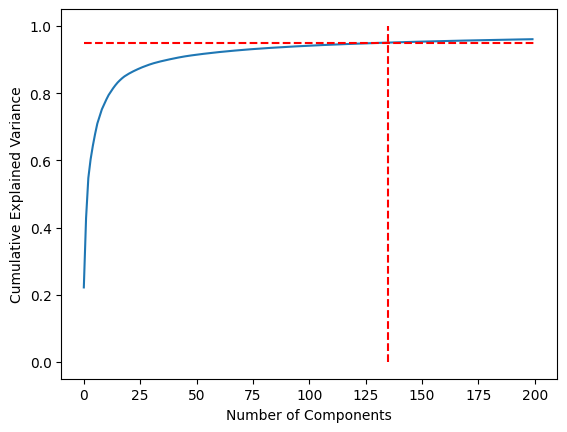

Number of components explaining 95% of the variance: 135


In [17]:
cumulative_variance = np.cumsum(explained_variance)
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.hlines(0.95, 0, 200, color='r', linestyle='--')
plt.vlines(135, 0, 1, color='r', linestyle='--')
plt.show()

# Select the number of components that explain, say, 95% of the variance
n_components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1
print(f"Number of components explaining 95% of the variance: {n_components_95}")

In [15]:
del(pca,X)

This took approximately 20 minutes and filled up a big part of RAM memory with only 3500 images. Thus we decided to try another way.

In [19]:
def process_batch(image_paths, img_h, img_w, norm_means, norm_std):
    with ThreadPoolExecutor(max_workers=16) as executor:
        flattened_images = list(tqdm(executor.map(lambda img_path: transormations_apply(img_path, img_h, img_w, norm_means, norm_std).flatten(), image_paths), total=len(image_paths)))
    return np.array(flattened_images)


from sklearn.decomposition import IncrementalPCA

n_components = 135
ipca = IncrementalPCA(n_components=n_components)

batch_size = 3500  

for i in range(0, len(data['image_path']), batch_size):
    batch_paths = data['image_path'][i:i + batch_size]
    X_batch = process_batch(batch_paths, img_h, img_w, norm_means, norm_std)
    ipca.partial_fit(X_batch)

  0%|          | 0/3500 [00:00<?, ?it/s]

100%|██████████| 3500/3500 [00:13<00:00, 266.74it/s]


We stoped it here because it filled 32gb RAM memory

# Scale-Invariant Feature Transform

In [18]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier()

In [20]:
def process_images_in_batches(df, batch_size):
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i + batch_size]
        images = []
        labels = []

        for _, row in batch.iterrows():
            img_path = row['image_path']
            label = row.get('dx_cat', None)  

            transformed_image = transormations_apply(img_path, img_h, img_w, norm_means, norm_std)
            images.append(transformed_image)

            if label is not None:
                labels.append(label)

        yield np.array(images), np.array(labels)

In [23]:
batch_size = 3500  
total_batches = len(data) // batch_size + (0 if len(data) % batch_size == 0 else 1)

for images_batch, labels_batch in tqdm(process_images_in_batches(data, batch_size), total=total_batches):
    # Reshape the images batch to be suitable for the classifier
    images_batch_reshaped = images_batch.reshape(images_batch.shape[0], -1)

    # Partially fit the model on this batch
    clf.partial_fit(images_batch_reshaped, labels_batch, classes=np.unique(data['dx_cat'])) 


100%|██████████| 21/21 [06:34<00:00, 18.77s/it]


In [24]:
clf

SGDClassifier()